In [58]:
from fastai.text import *
import html
import pandas as pd
from src.text_tools import fixup, get_texts, get_all
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from fastai.text.interpret import TextClassificationInterpretation
from sklearn.metrics import precision_recall_fscore_support
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
version = 'v1'
datadir = '/data/smith-monuments-sentiment/data'
data_lm = load_data(f'{datadir}/{version}/lm', 'data_lm_export.pkl')
trn_data = pd.read_csv(f'{datadir}/{version}/clas/train.csv')
test_data = pd.read_csv(f'{datadir}/clas/test.csv', names=['label', 'text'])
val_data = pd.read_csv(f'{datadir}/{version}/clas/test.csv')
data_clas = TextClasDataBunch.from_df(f'{datadir}/{version}/clas', train_df=trn_data, \
                                      valid_df=val_data,\
                                      test_df=test_data,\
                                      vocab=data_lm.train_ds.vocab, \
                                      bs=64)

In [61]:
#get class_weights
df = pd.read_csv(f'{datadir}/Master_monuments_comments.csv').dropna(subset=['sentiment'])
#df = pd.read_csv(f'{datadir}/v1/clas/train.csv').dropna(subset=['label'])
class_weights = class_weight.compute_class_weight('balanced',\
                                       np.unique(df['sentiment']),(df['sentiment']))

#class_weights = class_weight.compute_class_weight('balanced',\
#                                       np.unique(df['label']),(df['label']))
print(class_weights)
cls_wgts = torch.cuda.FloatTensor(class_weights)

[30.129771  0.362876  4.738295]


In [62]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6)
classifier.load_encoder(f'{datadir}/{version}/ft_enc')
classifier.crit = nn.CrossEntropyLoss(weight=cls_wgts)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


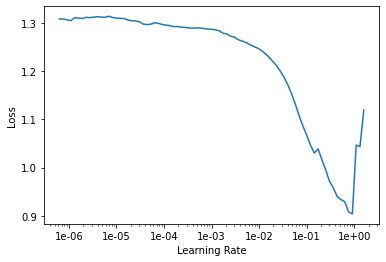

In [63]:
classifier.lr_find()
classifier.recorder.plot()

In [64]:
classifier.fit_one_cycle(1, 1e-2)

In [65]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))

In [111]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(2e-3/100, 2e-3))

In [112]:
classifier.save(f'{datadir}/{version}/clas/clas_model')

In [103]:
#classifier.load(f'{datadir}/{version}/clas/clas_model')

In [104]:
#results = [np.array(classifier.predict(text)[2]) for text in cls_test['text']]

In [113]:
preds, y, losses = classifier.get_preds(ds_type=DatasetType.Valid, with_loss=True)
#preds, y, losses = classifier.get_preds(ds_type=DatasetType.Test, with_loss=True)
#interp = ClassificationInterpretation(val_data, preds, y, losses)

In [114]:
#yhat = np.argmax(np.array(preds)*(class_weights), axis=1)
yhat = np.argmax((np.array(preds)),axis=1)
y = np.array(val_data.label)
#y = np.array(test_data.label)
cm = confusion_matrix(y, yhat)

Normalized confusion matrix
[[0.545455 0.272727 0.181818]
 [0.001951 0.996098 0.001951]
 [0.       0.222222 0.777778]]


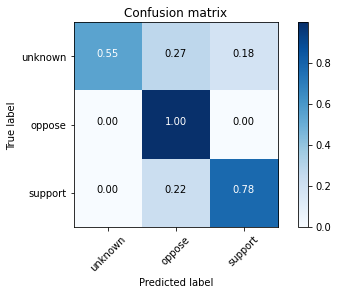

In [115]:
plot_confusion_matrix(cm, ['unknown', 'oppose', 'support'],normalize=True)

Confusion matrix, without normalization
[[   6    3    2]
 [   2 1021    2]
 [   0   10   35]]


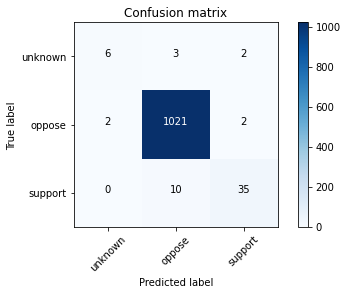

In [116]:
plot_confusion_matrix(cm, ['unknown', 'oppose', 'support'])

In [117]:
precision_recall_fscore_support(y, yhat)

(array([0.75    , 0.987427, 0.897436]),
 array([0.545455, 0.996098, 0.777778]),
 array([0.631579, 0.991744, 0.833333]),
 array([  11, 1025,   45]))

In [110]:
interp = TextClassificationInterpretation.from_learner(classifier)

In [99]:
test_text="They were opposed to Katahdin monument, but now think that the local people should decide and they don't care if it is or is not a monument. For over 20 years my husband & I have traveled to the North ME Woods to hunt, fish, & snowmobile.  When the possibility of a park or monument was proposed for the Katahdin region we were completely opposed to it.  However, we believed that the decision should rest with the people who lived there & not people like us who do not. (We live in the Bangor, ME  area).  We think that former President Obama gravely overstepped his bounds when he ignored the wishes of the people of the area and designated a monument.However, now that the monument is a reality and there appears to be some signs of economic growth, people in the area may be more supportive of it.  If they are, they should have it.  If  they are not, it should be overturned."

In [100]:
from matplotlib import cm
interp.show_intrinsic_attention(test_text, cmap=cm.viridis)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [101]:
test_text="all protections and preservations for the entire country of America are well deserved and need to be sustained. In fact, we shuld continuesaving protecting and preserving additional lands for the environmental protection of all of America. those lands savedare utilized by people all over America. we are a united country and all of us protect all of the rest of us so that it is evil and ugly to try to bring into this protection making states fight with each other. that is wrong and against the American spirit. one forall, all for one or we don't have a union. this call to start taking back what we saved for all of us, is an evil act. public commentwas taken at the times these lands were preserved and there is no reason to go back on what was protected and preserved.I am surprised that this evil act of trying to stop saving and protecting gods lands doesn't go back to l700.  I am very muchopposed to this plan by president trump. that open space protects all of us by keeping in place nature, which is the only thingkeeping u s alive anymore. you all can see how industry, like in china, where they cant breathe the air healthfully, is what industry bringin. india is another country with huge developments tha bring with it bad air, bad soil and bad water."
test_text="I am in favor of keeping all existing monuments (including but not limited to grand staircase, bears ears and katahdin woods) in place as is, and not downsizing them. I have no problems with the use of the antiquities act used to designate these monuments. I believe these monuments are public goods in the truest sense of the term, and should be protected as such. I also believe that these monuments are economically helping out their respective communities. Please protect our national monuments; they are treasures, and should be kept as such."
test_text="When you look at what other leading industrialized nations are doing (Korea, Japan, Finland, Singapore) they are looking for ways to immerse their populations in the outdoors to reduce stress and improve both mental and physical health.We are blessed in the United States to have spaces which are still available for today and for tomorrow to offer access to a variety of ecosystems.  It is up to us to continue to provide protection for these places so that future generations can take advantage of the physical and mental benefits that wild places offer.The Antiquities Act, created by a Republican Theodore Roosevelt, enables the preservation of these wild spaces.  Don't be the Republican who takes them away."
test_text="Giving up a national monument is an irreversible decision if the land is used for other purposes. These are treasures, and we have a huge amount of open space that can be used aside from these areas. Leave them alone."
interp.show_intrinsic_attention(test_text, cmap=cm.viridis)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [90]:
interp.show_top_losses(k=50, max_len=100)

In [185]:
from matplotlib.colors import LinearSegmentedColormap
div = 255.
neu_color = tuple(x/div for x in (146,197,222))
opp_color = tuple(x/div for x in (230,97,1))
sup_color = tuple(x/div for x in (94,60,153)) # R -> G -> B
colors = [neu_color, opp_color, sup_color]  # R -> G -> B
cmap_name = 'custom_map'
nbins = 6
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=nbins)

In [187]:
i = 361 
test_text = test_data.text.loc[i]
interp.show_intrinsic_attention(test_text, cmap=cmap)

/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/cuda/LegacyDefinitions.cpp:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
